# Summary

I will start with linear regression as base model. 

+ I add quantitative features incrementally to see their impact on prediction perf
+ I will also figure out what is the best perf of a linear model

Then we will switch to ensemble models:
+ random forest
+ tune hyperparams of RF to achieve a better model. 

We will pick features based on analysis from my [EDA notebook](https://www.kaggle.com/victor191/eda-and-smart-feature-engineer).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold

In [2]:
# folder = '/kaggle/input/house-prices-advanced-regression-techniques/'
folder = 'data'

train = pd.read_csv(os.path.join(folder, 'train.csv'))
test = pd.read_csv(os.path.join(folder, 'test.csv'))

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
# concat train and test sets st we always perform transformation on both sets
test['SalePrice'] = 0
data = pd.concat([train, test])

print(data.shape)

# lowercase all column names for convenience
data.columns = [str.lower(cc) for cc in data.columns]

# sale price per square feet is also interested
# data['sale_price_per_sf'] = data['saleprice'] / data['grlivarea']

(2919, 81)


There are two approaches:
+ predict directly sale price
+ predict price per SF, then multiply with living area to estimate sale price

I plan to try both, but first we need some helpers.

## Helper methods

In [4]:
def cal_age_from_built(row):
    return row['yrsold'] - row['yearbuilt']

def cal_age_from_remodel(row):
    return row['yrsold'] - row['yearremodadd']


def fold_zone_type(ms_zone):
    if ms_zone in ['FV', 'RH', 'C (all)']:
        return 'Other'
    else:
        return ms_zone
#         return {'RL': 'Residential Low Density'.lower() , 
#                 'RM': 'Residential Medium Density'.lower(),
#                 None: 'NA'
#                }[ms_zone]    

def to_adjacency(cond):
    if 'RR' in cond:
        return 'Railroad'
    if 'Pos' in cond:
        return 'Positive feature'
    return {
        'Artery': 'Arterial street',
        'Feedr': 'Feeder street',
        'Norm': 'Normal'    
        }[cond]

In [5]:
# TODO: change this to imports from util

In [6]:
def onehot_encode(cat_feat, data, dummy_na=False):
    # given a categorical column,
    # perform onehot encode and return encoded DF together with names of new binary columns
    categories = data[cat_feat].unique()
    print('there are', len(categories), 'categories as follows:')
    print(categories)
    
    encoded = pd.get_dummies(data[cat_feat], prefix=cat_feat, dummy_na=dummy_na)
    res = pd.concat([data.drop(columns=[cat_feat]), encoded], axis='columns')
    new_feat_names = ['_'.join([cat_feat, cc]) for cc in categories]
    return res, new_feat_names

def encode_cat_feats(data, cat_feats, dummy_na=False):
    print('Onehot encode categorical features: ', cat_feats)

    encoded_df = data.copy()
    # encode 1 cat feature at a time
    for cf in cat_feats:
        encoded_df, _ = onehot_encode(cf, encoded_df, dummy_na=dummy_na)

    return encoded_df

In [7]:
def list_numeric_columns(data):
    return list(data.columns[np.where(data.dtypes != 'object')])

def list_string_columns(data):
    return list(data.columns[np.where(data.dtypes == 'object')])

def split_train_valid(data, target):
    y = data.pop(target)
    X = data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.1, 
                                                          random_state=1
                                                         )
    return X_train, X_valid, y_train, y_valid

def check_na(data):
    # return the columns having NAs, sorted descendingly by their number of NAs
    na_count = [sum(data[ff].isnull()) for ff in data.columns]
    return pd.DataFrame({'column': data.columns, 'na_count': na_count}).\
              query('na_count > 0').sort_values('na_count', ascending=False)  

In [8]:
def to_quantitative(text_feat, df, scoring):
    '''
    Given a feature stored in data as text but actually a quantitative feat, convert it to numerical values
    via given encoding
    :param scoring:
    :param text_feat:
    :return:
    '''
    n_na = sum(df[text_feat].isnull())
    print('\t Feature {0} has {1} NAs, they will be filled by 0'.format(text_feat, n_na))

    res = df.copy()
    res[text_feat].fillna("NA", inplace=True)
    res[text_feat] = res[text_feat].apply(lambda form: scoring[form])
    return res

def quant_to_scores(quant_feats, data, scorings):
    print('\n Converting quantitative text features to scores...')
    score_dict = dict(zip(quant_feats, scorings))
    
    for tf in quant_feats:  
        data = to_quantitative(text_feat=tf, df=data, scoring=score_dict[tf])

    return data

In [9]:
def make_output(y_pred):
    test_index = range(len(train) + 1, len(data) + 1)
    return pd.DataFrame({'Id': test_index, 'SalePrice': y_pred})

In [10]:
def get_train_tests(data, target):
    train_part = data.loc[data[target] > 0].copy()
    test_part = data.loc[data[target] == 0].copy()
    return train_part, test_part

## Preprocessing

In [11]:
target = 'saleprice'
y_train = data.loc[data[target] > 0][target]

### Handle missing values

In [12]:
num_vars = list_numeric_columns(data.drop(columns=['id', target]))

In [13]:
na_checker = check_na(data[num_vars] ).sort_values('na_count', ascending=False).\
    reset_index(drop=True)
print(na_checker)

          column  na_count
0    lotfrontage       486
1    garageyrblt       159
2     masvnrarea        23
3   bsmtfullbath         2
4   bsmthalfbath         2
5     bsmtfinsf1         1
6     bsmtfinsf2         1
7      bsmtunfsf         1
8    totalbsmtsf         1
9     garagecars         1
10    garagearea         1


Fill NAs in certain numeric vars by their means.

In [14]:
data[num_vars] = data[num_vars].fillna(data[num_vars].mean())

In [15]:
check_na(data[num_vars])

,column,na_count


In [16]:
train_part, test_part = get_train_tests(data, target)

# Simple model
LInear regressors with no derived features.

In [17]:
feats0 = ['overallqual',
          'yearbuilt', 'mosold', 'yrsold', 'grlivarea', 'lotarea'
         ]
# overallcond

In [18]:
y_train = train_part[target]

In [19]:
X_train = train_part[feats0]
X_test = test_part[feats0]

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('score of linear regressor', lr.score(X_train, y_train))

alphas = np.linspace(-3, 0, 4)
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)
print('score of ridge regressor', ridge.score(X_train, y_train))

score of linear regressor 0.7497036340620418
score of ridge regressor 0.7497036340620418


Ridge and base linear regressors have same score. So we only need linear regressor.

## Numeric features

In [21]:
num_cols = list_numeric_columns(data)
print(num_cols)

['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']


In [22]:
check_na(data[num_cols]).sort_values('na_count', ascending=False)

,column,na_count


In [23]:
feats0 = ['overallqual',
          'yearbuilt', 'mosold', 'yrsold', 'grlivarea', 'lotarea'
         ]
# overallcond

__note__: adding var "overallcond" pull down prediction perf a lot, so this var has problem.

In [24]:
lr = LinearRegression()

In [25]:
# features for bathrooms, bedrooms
room_feats = ['bedroomabvgr', 'fullbath', 'halfbath',
              'kitchenabvgr', 'totrmsabvgrd'
             ] # total_bath

In [26]:
X_train = train_part[feats0 + room_feats]
X_test = test_part[feats0 + room_feats]

lr.fit(X_train, y_train)
print('score of linear regressor', lr.score(X_train, y_train))

score of linear regressor 0.7668627922722758


In [27]:
# area-related features
area_feats = ['1stflrsf', '2ndflrsf', 'lowqualfinsf', 'masvnrarea']

+ adding "masvnrarea" boost prediction a bit more

In [28]:
X_train = train_part[feats0 + room_feats + area_feats]
X_test = test_part[feats0 + room_feats + area_feats]

lr.fit(X_train, y_train)
print('score of linear regressor', lr.score(X_train, y_train))

score of linear regressor 0.7811771495492964


In [29]:
check_na(data[['bsmtfinsf1', 'bsmtunfsf',]])

,column,na_count


In [30]:
# basement features
# a potential feature is ratio between unfinished basement area and total area

# data['bsmt_unfinished_ratio'] = data['bsmtunfsf'] / data['totalbsmtsf']
bsmt_feats = [ 'totalbsmtsf', 
             ] 
# 'bsmtfullbath', 'bsmthalfbath',  
# 'bsmtunfsf', 'bsmtfinsf2', 'bsmtfinsf1'

In [31]:
X_train = train_part[feats0 + room_feats  + bsmt_feats + area_feats]
X_test = test_part[feats0 + room_feats  + bsmt_feats + area_feats]

lr.fit(X_train, y_train)
round(lr.score(X_train, y_train), 4)

0.7832

In [32]:
# out_dir = '/kaggle/working'
out_dir = 'output/'

In [33]:
make_output(lr.predict(X_test)).to_csv(os.path.join(out_dir, 'lin_res.csv') , index=False)

+ Adding "bsmtunfsf" and "bsmtfinsf1" helps reach better score on train, but pull down prediction perf on test set. This maybe overfitting.

+ bsmt_unfinished_ratio has NA

In [34]:
# garage feats
gar_feats = [ 'garagecars', 'garagearea'] # garageyrblt: many NA

In [35]:
X_train = train_part[feats0 + room_feats + area_feats + bsmt_feats + gar_feats]
X_test = test_part[feats0 + room_feats + area_feats + bsmt_feats + gar_feats]

In [36]:
check_na(X_train)

,column,na_count


In [37]:
lr.fit(X_train, y_train)
round(lr.score(X_train, y_train), 4)

0.7897

In [38]:
make_output(lr.predict(X_test)).to_csv(os.path.join(out_dir, 'lin_res_2.csv') , index=False)

+ adding garage features not help, so drop them

In [39]:
feats = feats0 + room_feats  + bsmt_feats + area_feats

# Categorical features

To pick good features among categorical vars, we need a way to measure the correlation between a categorical var and our continuous target. Here comes eta correlation and its python implementation (dython).

## Helpers for categorical correlaton

In [40]:
!pip install dython

In [41]:
from dython.nominal import correlation_ratio, associations

+ for correlation between 2 categorical vars, check method theils_u in dython

In [42]:
cat_feats = list_string_columns(data)
print('# cat feats: ', len(cat_feats))
print(cat_feats)

# cat feats:  43
['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature', 'saletype', 'salecondition']


In [43]:
eta_corrs = [correlation_ratio(train_part[cf], train_part[target]) for cf in cat_feats]
corr_target_cat_feats = pd.DataFrame({'cat_feat': cat_feats, 'corr_with_target': eta_corrs
                                     }).sort_values('corr_with_target', ascending=False)
corr_target_cat_feats

,cat_feat,corr_with_target
8,neighborhood,0.738630
18,exterqual,0.690933
21,bsmtqual,0.681905
30,kitchenqual,0.675721
34,garagefinish,0.553059
32,fireplacequ,0.542181
20,foundation,0.506328
33,garagetype,0.499204
24,bsmtfintype1,0.459141
27,heatingqc,0.442154


As expected: 
+ "neighborhood" has very high correlation with target, as it is purely categorical feats, I will deal with it later
+ "exterqual" and "kitchenqual" also has high correlation with target, so I will encode them by proper scales.

In [44]:
qual_feats = ['exterqual', 'kitchenqual', 'bsmtqual']
data[qual_feats].describe()

,exterqual,kitchenqual,bsmtqual
count,2919,2918,2838
unique,4,4,4
top,TA,TA,TA
freq,1798,1492,1283


In [45]:
data['exterqual'].unique()
data['kitchenqual'].unique()
data['bsmtqual'].unique()

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

In [46]:
six_scale = {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0}
scorings = [six_scale]*len(qual_feats)

data = quant_to_scores(qual_feats, data, scorings)
train_part, test_part = get_train_tests(data, target)


 Converting quantitative text features to scores...
	 Feature exterqual has 0 NAs, they will be filled by 0
	 Feature kitchenqual has 1 NAs, they will be filled by 0
	 Feature bsmtqual has 81 NAs, they will be filled by 0


In [47]:
feats += qual_feats
X_train = train_part[feats]
X_test = test_part[feats]

In [48]:
lr.fit(X_train, y_train)
lr_score = round(lr.score(X_train, y_train), 4)

In [49]:
make_output(lr.predict(X_test)).to_csv(os.path.join(out_dir, 'lin_res_2.csv') , index=False)

C:\Users\Victor\Anaconda3\envs\updated\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


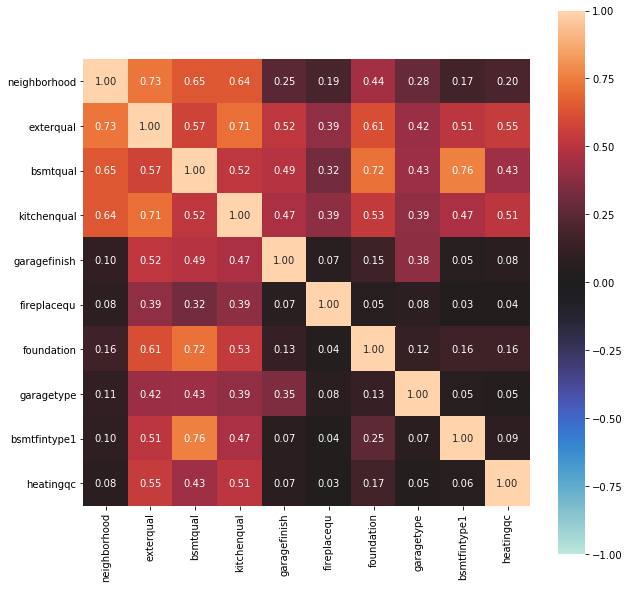

{'corr':               neighborhood  exterqual  bsmtqual  kitchenqual  garagefinish  \
 neighborhood      1.000000   0.733113  0.647577     0.640827      0.245090   
 exterqual         0.733113   1.000000  0.574608     0.714328      0.519179   
 bsmtqual          0.647577   0.574608  1.000000     0.521353      0.494451   
 kitchenqual       0.640827   0.714328  0.521353     1.000000      0.466644   
 garagefinish      0.102720   0.519179  0.494451     0.466644      1.000000   
 fireplacequ       0.081321   0.394946  0.317835     0.388542      0.069539   
 foundation        0.160065   0.613028  0.719689     0.532900      0.131706   
 garagetype        0.108315   0.421131  0.427433     0.393997      0.349166   
 bsmtfintype1      0.100314   0.512413  0.764801     0.468151      0.070998   
 heatingqc         0.076047   0.546385  0.432341     0.514941      0.071053   
 
               fireplacequ  foundation  garagetype  bsmtfintype1  heatingqc  
 neighborhood     0.190973    0.439727    0

In [50]:
# plot corr between 10 cat features with highest corr to target
top10_feats = corr_target_cat_feats.head(10)['cat_feat']
associations(data[top10_feats], theil_u=True, figsize=(10, 10))

In [51]:
# to reduce minority 
data['zone_type'] = data['mszoning'].apply(fold_zone_type)
data['adjacency'] = data['condition1'].apply(to_adjacency)
train_part, test_part = get_train_tests(data, target)

In [52]:
[correlation_ratio(train_part[cf], train_part[target]) 
 for cf in ['zone_type', 'adjacency']
]

[0.28880288249977604, 0.17293552989193986]

## Encode categorical features

I will perform onehot encoding incrementally, starting with features having highest correlations with target.

In [53]:
check_na(data[['neighborhood']])

,column,na_count


In [54]:
# nbhood
encoded_data, nbh_feats = onehot_encode('neighborhood', data)
print(encoded_data.shape)

there are 25 categories as follows:
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
(2919, 107)


In [55]:
encoded_data[nbh_feats] .head()

,neighborhood_CollgCr,neighborhood_Veenker,neighborhood_Crawfor,neighborhood_NoRidge,neighborhood_Mitchel,neighborhood_Somerst,neighborhood_NWAmes,neighborhood_OldTown,neighborhood_BrkSide,neighborhood_Sawyer,...,neighborhood_Edwards,neighborhood_Timber,neighborhood_Gilbert,neighborhood_StoneBr,neighborhood_ClearCr,neighborhood_NPkVill,neighborhood_Blmngtn,neighborhood_BrDale,neighborhood_SWISU,neighborhood_Blueste
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
train_part, test_part = get_train_tests(encoded_data, target)

In [57]:
feats += nbh_feats
X_train = train_part[feats]
X_test = test_part[feats]

# Random forest



In [58]:
base_rf = RandomForestRegressor(n_estimators=100, max_features=1.0, n_jobs=-1,
                               random_state=1,
                               )

In [59]:
base_rf.fit(X_train, y_train)
rf_score = round(base_rf.score(X_train, y_train), 4)
rf_score

0.9802

In [60]:
y_pred = base_rf.predict(X_test)
make_output(y_pred).to_csv(os.path.join(out_dir, 'rf_res.csv') , index=False)

In [61]:
100 * (rf_score - lr_score)/lr_score

22.70906359539309

+ adding neighborhood has a whooping effect. It boosts score by >20% and advanced me >450 places on leaderboard.
+ now we add the next relevant categorical var, "foundation" (this is because kitchen and exterior qualities are already added). But should expect that the impact may be marginal, as the correlation is not that high.

In [62]:
# adding foundation
data.foundation.value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: foundation, dtype: int64

In [63]:
check_na(data[['foundation']])

,column,na_count


In [64]:
encoded_data, fdn_feats = onehot_encode('foundation', encoded_data)

there are 6 categories as follows:
['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']


In [65]:
train_part, test_part = get_train_tests(encoded_data, target)

In [66]:
feats += fdn_feats
X_train = train_part[feats]
X_test = test_part[feats]

In [67]:
base_rf.fit(X_train, y_train)
rf_score = round(base_rf.score(X_train, y_train), 4)
rf_score

0.98

In [68]:
%store feats

Stored 'feats' (list)


+ as expected "foundation" not help at all, it even pulls down perf.

# Encoding schemes for nominal vars

In [69]:
# !pip install category_encoders

In [70]:
import category_encoders as ce

In [71]:
cat_feats = list_string_columns(data)
print('# categ feats:', len(cat_feats))

# categ feats: 42


In [72]:
def eval_perf(encoder, cat_feats, initials='cb'):
    encoder.fit(train[cat_feats], train[target])

    encoded_train = train.join(encoder.transform(train[cat_feats]).add_suffix('_' + initials)).drop(columns=cat_feats)
    encoded_test = test.join(encoder.transform(test[cat_feats]).add_suffix('_' + initials)).drop(columns=cat_feats)
    
    #     fill NAs
    num_feats = list_numeric_columns(encoded_train)
    encoded_train[num_feats] = encoded_train[num_feats].fillna(encoded_train[num_feats].mean())
    encoded_test[num_feats] = encoded_test[num_feats].fillna(encoded_test[num_feats].mean())

    features = encoded_train.columns.drop([target, 'id'])
    # print(features)

    base_rf.fit(encoded_train[features], encoded_train[target])
    score = round(base_rf.score(encoded_train[features], encoded_train[target]), 4)
    return score

## Target encoding

Encode each category by mean value of target within that category.

In [73]:
train, test = get_train_tests(data, target)

In [74]:
target_enc = ce.TargetEncoder(cols=cat_feats)
target_enc.fit(train[cat_feats] , train[target])

TargetEncoder(cols=['mszoning', 'street', 'alley', 'lotshape', 'landcontour',
                    'utilities', 'lotconfig', 'landslope', 'neighborhood',
                    'condition1', 'condition2', 'bldgtype', 'housestyle',
                    'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd',
                    'masvnrtype', 'extercond', 'foundation', 'bsmtcond',
                    'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating',
                    'heatingqc', 'centralair', 'electrical', 'functional',
                    'fireplacequ', ...])

In [75]:
# Transform the features, 
# rename the columns with _target suffix, and join to dataframe
# also remove old categ vars
train_te = train.join(target_enc.transform(train[cat_feats]).add_suffix('_target')).drop(columns=cat_feats)
test_te = test.join(target_enc.transform(test[cat_feats]).add_suffix('_target')).drop(columns=cat_feats)

In [76]:
features = train_te.columns.drop([target, 'id'])
# print(features)

In [77]:
print(num_vars)

['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold']


In [78]:
check_na(train_te)

,column,na_count


In [79]:
base_rf = RandomForestRegressor()

base_rf.fit(train_te[features], train_te[target])
round(base_rf.score(train_te[features], train_te[target]), 4)

0.9814

In [80]:
y_pred = base_rf.predict(test_te[features])
make_output(y_pred).to_csv(os.path.join(out_dir, 'rf_res_te.csv') , index=False)

## Encode by other statistics of target (Experiment)

In [81]:
def flatten_columns(data):
    data.columns = ['_'.join(reversed(list(col))) for col in data.columns.values]
    return data

In [82]:
# try neighborhood
nbh_stats = flatten_columns(train.groupby('neighborhood').agg({target: [  np.std]})).\
    add_suffix('_by_neighborhood').reset_index()
nbh_stats.head()

,neighborhood,std_saleprice_by_neighborhood
0,Blmngtn,30393.229219
1,Blueste,19091.883092
2,BrDale,14330.176493
3,BrkSide,40348.689270
4,ClearCr,50231.538993


In [83]:
target_enc = ce.TargetEncoder(cols=cat_feats)
target_enc.fit(train[cat_feats] , train[target])
# target_enc.transform(train[cat_feats]).head()

TargetEncoder(cols=['mszoning', 'street', 'alley', 'lotshape', 'landcontour',
                    'utilities', 'lotconfig', 'landslope', 'neighborhood',
                    'condition1', 'condition2', 'bldgtype', 'housestyle',
                    'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd',
                    'masvnrtype', 'extercond', 'foundation', 'bsmtcond',
                    'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating',
                    'heatingqc', 'centralair', 'electrical', 'functional',
                    'fireplacequ', ...])

In [84]:
# Transform the features, 
# rename the columns with _target suffix, and join to dataframe
# also remove old categ vars
train_te = train.join(target_enc.transform(train[cat_feats]).add_suffix('_target'))
test_te = test.join(target_enc.transform(test[cat_feats]).add_suffix('_target'))

# add variance of price per nbh
train_te = train_te.merge(nbh_stats)
test_te = test_te.merge(nbh_stats)
# print(len(train_te))
# print(len(test_te))

train_te = train_te.drop(columns=cat_feats)
test_te = test_te.drop(columns=cat_feats)

In [85]:
# TODO: try integrating info of std via confidence interval
# train_te['conf_']

In [87]:
features = train_te.columns.drop([target, 'id'])
print(list(features))

['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'exterqual', 'bsmtqual', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'mszoning_target', 'street_target', 'alley_target', 'lotshape_target', 'landcontour_target', 'utilities_target', 'lotconfig_target', 'landslope_target', 'neighborhood_target', 'condition1_target', 'condition2_target', 'bldgtype_target', 'housestyle_target', 'roofstyle_target', 'roofmatl_target', 'exterior1st_target', 'exterior2nd_target', 'masvnrtype_target', 'extercond_target', 'foundation_target', 'bsmtcond_target', 'bsmtexposure_target', 'bsmtfintype1_

In [89]:
base_rf = RandomForestRegressor()

base_rf.fit(train_te[features], train_te[target])
round(base_rf.score(train_te[features], train_te[target]), 4)

0.9812

In [90]:
y_pred = base_rf.predict(test_te[features])
make_output(y_pred).to_csv(os.path.join(out_dir, 'rf_res_te2.csv') , index=False)

## CatBoost encoding

In [91]:
cbe = ce.CatBoostEncoder(cols=cat_feats)

cbe.fit(train[cat_feats], train[target])

CatBoostEncoder(cols=['mszoning', 'street', 'alley', 'lotshape', 'landcontour',
                      'utilities', 'lotconfig', 'landslope', 'neighborhood',
                      'condition1', 'condition2', 'bldgtype', 'housestyle',
                      'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd',
                      'masvnrtype', 'extercond', 'foundation', 'bsmtcond',
                      'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating',
                      'heatingqc', 'centralair', 'electrical', 'functional',
                      'fireplacequ', ...])

In [92]:
# cbe.transform(train[cat_feats]).add_suffix('_cb').head()

In [93]:
train_cb = train.join(cbe.transform(train[cat_feats]).add_suffix('_cb')).drop(columns=cat_feats)
test_cb = test.join(cbe.transform(test[cat_feats]).add_suffix('_cb')).drop(columns=cat_feats)

In [94]:
num_feats = list_numeric_columns(train_cb)
train_cb[num_feats] = train_cb[num_feats].fillna(train_cb[num_feats].mean())
test_cb[num_feats] = test_cb[num_feats].fillna(test_cb[num_feats].mean())

In [95]:
features = train_cb.columns.drop([target, 'id'])
print(features)

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'masvnrarea', 'exterqual', 'bsmtqual',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf',
       '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
       'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'fireplaces', 'garageyrblt', 'garagecars', 'garagearea',
       'wooddecksf', 'openporchsf', 'enclosedporch', '3ssnporch',
       'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'mszoning_cb',
       'street_cb', 'alley_cb', 'lotshape_cb', 'landcontour_cb',
       'utilities_cb', 'lotconfig_cb', 'landslope_cb', 'neighborhood_cb',
       'condition1_cb', 'condition2_cb', 'bldgtype_cb', 'housestyle_cb',
       'roofstyle_cb', 'roofmatl_cb', 'exterior1st_cb', 'exterior2nd_cb',
       'masvnrtype_cb', 'extercond_cb', 'foundation_cb', 'bsmtcond_cb',
       'bsmtexposure_cb', 'bsmt

In [96]:
base_rf.fit(train_cb[features], train_cb[target])
round(base_rf.score(train_cb[features], train_cb[target]), 4)

0.9806

In [97]:
y_pred = base_rf.predict(test_cb[features])
make_output(y_pred).to_csv(os.path.join(out_dir, 'rf_res_cb.csv') , index=False)

CatBoost encoding gives similar result.

# Feature generation 
(to be moved to another notebook)

How to generate features _useful for prediction_, esp. house price?

Ideas:
+ diff from avg: features signaling how much a house diff from an avg house in same neighborhood
+ features revealing benefit: features for quality (avail), close to school (no data), close to park (avail)
+ feature revealing cost: need renovation (as no reno yet), renovate cost? 

How about feature interaction?